# ALGONQUIN
This notebook implements the ALGONQUIN algorithm from literature.

## Load packages

In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using LinearAlgebra
using PyPlot
using Compat
using WAV
using Base64
using DSP
using FFTW
using Distributions
using GaussianMixtures
using ProgressMeter
using BenchmarkTools

include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/preprocessing.jl")
;

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


## Set parameters

In [2]:
# signal preprocessing
sound_file1 = "../data/woman.wav"     # specify sound location
sound_file2 = "../data/airco.wav"     # specify sound location
fs_desired = 8000                     # specify desired sampling frequency
normalization_method = "max"          # specify normalization method
μ = 255                               # specify parameter for μ-law companding and expansion
nr_freqs = 40                         # specify number of Fourier coefficients
pole_location = 0.4092                # specify pole location of warped filter bank (fs=8000: ~4092, fs=16000: ~0.5756)
step_size = 20                         # specify desired stepsize (currently trade-off between step size and distortion) TODO: ask Tanya, Bert or Joris
;

In [3]:
function ALGONQUIN(μs::Array{Float64,1}, Σs::Diagonal{Float64,Array{Float64,1}}, g, gprime, Ψ::Diagonal{Float64,Array{Float64,1}}, y::Array{Float64,1}, πs::Float64, iterations::Int64=5)::Tuple{Array{Float64,1},Float64} 
    # set initial parameters
    ηs = μs
    Φs = Matrix(Σs)

    # calculate inverses to save time
    iΨ = inv(Ψ)
    iΣ = inv(Σs)
    
    # iterative laplace
    @inbounds for _ = 1:iterations
        
        gprime_ηs = gprime(ηs)

        # update Φs
        Φs = inv(Matrix(iΣ + gprime_ηs'*iΨ*gprime_ηs))

        # update ηs
        ηs = ηs + Φs * (iΣ*(μs - ηs) + gprime_ηs'*iΨ*(y-g(ηs)))

    end

    gprime_ηs = gprime(ηs)
    y_g_ηs = y - g(ηs)
    ηs_μs = ηs - μs
    
    # update responsibilties (leave out λ for later normalization and apply trick of https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/)
    ρs = log(πs) -
         1/2*log(2*pi*det(Σs)) +
         1/2*log(2*pi*det(Φs)) -
         1/2*(y_g_ηs)'*iΨ*(y_g_ηs) -
         1/2*tr(iΣ*Φs) -
         1/2*(ηs_μs)'*iΣ*(ηs_μs) -
         1/2*tr(gprime_ηs'*iΨ*gprime_ηs*Φs)
    
    # return posterior beliefs
    return ηs, ρs
end
;

## Create functions for algorithm

In [4]:
function ALGONQUIN_frame(g_speech, g_noise, data::Array{Float64,1})::Array{Float64,1}
    
    # get nr clusters
    Ns = g_speech.n
    Nn = g_noise.n

    # create array for algorithm output
    η = Array{Array{Float64,1},1}(undef, Ns*Nn)
    ρ = Vector{Float64}(undef, Ns*Nn)

    # get value of M 
    M = length(data)
    d = ones(M)
    d1 = 3*Diagonal(d)

    # loop through different mixture models
    @inbounds for s = 1:Ns*Nn

        # set indices
        ni = ((s-1) % Nn) + 1
        si = Int(ceil(s/Nn))

        # calculate prior responsibilities
        πs = weights(g_speech)[si] * weights(g_noise)[ni]
        
        # set prior variables
        μs = vcat(means(g_speech)[si,:], means(g_noise)[ni,:], zeros(M))
        Σs = Diagonal(vcat(g_speech.Σ[si,:], g_noise.Σ[ni,:], 1e-10*d))
        
        # perform ALGONQUIN algorithm
        η[s], ρ[s] = ALGONQUIN(μs, Σs, logsumexp, J_logsumexp, d1, data, πs, 5)
        
    end
    
    # normalize ρ with trick to prevent underflow
    ρ = ρ .- maximum(ρ)
    ρ = exp.(ρ)./sum(exp.(ρ))
    
    # calculate estimate of speech and noise signals
    return sum(ρ.*η)
    
end;

In [5]:
function trainGMM(clusters::Int64, y::Array{Float64,2}, kind::Symbol)
    if (kind == :full) & isposdef(y)
        g = GMM(clusters, y, kind=kind)
        p = GMMprior(g.d, 0.1, 1.0)  ## set α0=0.1 and β0=1, and other values to a default
        v = VGMM(g, p) ## initialize variational GMM v with g
        em!(v, y)
    elseif (kind == :full) & ~isposdef(y)
        println("data matrix not posdef, going for diagonal GMM")
        g = GMM(clusters, y, kind=:diag)
        em!(g, y)
    else
        g = GMM(clusters, y, nIter=50, nInit=100, kind=:diag)
        em!(g, y)
    end
    return g
end;

In [6]:
function preprocess(x::Array{Float64,1}, fs::Int64; fs_desired::Int64=8000, normalization_method::String="max")
    y = resample(x, fs_desired/fs)
    y = normalize(y, normalization_method)
    return y
end;

In [7]:
function logsumexp(y::Array{Float64,1})
    # fetch length of single segment
    M = Int(length(y)/3)
    
    # get x, h n
    x = y[0*M+1:1*M]
    n = y[1*M+1:2*M]    
    h = y[2*M+1:3*M]
    
    return h + x + log.(1 .+ exp.(n-h-x))
end;

In [8]:
function J_x_logsumexp(x::Array{Float64,1}, n::Array{Float64,1}, h::Array{Float64,1})
    return Diagonal(1 .- exp.(n - h - x)./(1 .+ exp.(n - h - x)))
end

function J_n_logsumexp(x::Array{Float64,1}, n::Array{Float64,1}, h::Array{Float64,1})
    return Diagonal(exp.(n - h - x)./(1 .+ exp.(n - h - x)))
end

function J_h_logsumexp(x::Array{Float64,1}, n::Array{Float64,1}, h::Array{Float64,1})
    return Diagonal(1 .- exp.(n - h - x)./(1 .+ exp.(n - h - x)))
end

function J_logsumexp(y::Array{Float64,1})
    # fetch length of single segment
    M = Int(length(y)/3)
    
    # get x, h n
    x = y[0*M+1:1*M]
    n = y[1*M+1:2*M]    
    h = y[2*M+1:3*M]

    
    return hcat(J_x_logsumexp(x,n,h), J_n_logsumexp(x,n,h), J_h_logsumexp(x,n,h))
end;

## Load and process signals

In [9]:
# load speech data
x_speech, fs_speech = wavread(sound_file1, format="native")
fs_speech = Int(fs_speech)
x_speech = convert(Array{Float64,1}, squeeze(x_speech[:,1]))[1*fs_speech:4*fs_speech]

# load noise data
x_noise, fs_noise = wavread(sound_file2, format="native")
fs_noise = Int(fs_noise)
x_noise = convert(Array{Float64,1}, squeeze(x_noise[:,1]))[1*fs_noise:4*fs_noise]

# pre-process signals
y_speech = preprocess(x_speech, fs_speech)
y_noise = preprocess(x_noise, fs_noise)
y_tot = y_noise + y_speech

# warp signal and take fft
f_speech = warp_fft(y_speech, pole_location, nr_freqs, step_size=step_size)
f_noise = warp_fft(y_noise, pole_location, nr_freqs, step_size=step_size)
f_tot = warp_fft(y_tot, pole_location, nr_freqs, step_size=step_size)

# get the log abs values
z_speech = log.(abs2.(f_speech))[:,1:Int(nr_freqs/2+1)]
z_noise = log.(abs2.(f_noise))[:,1:Int(nr_freqs/2+1)]
z_tot = log.(abs2.(f_tot))[:,1:Int(nr_freqs/2+1)]

# create audioplayers for signals
audioplayers(y_speech, y_noise, y_tot, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRkB3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQR3AQAXLxC+z7Zpvpv5Nb7BxRS+yVvfvUVPfL38sEc9gVMKPp4fZT6sOp8+RpLDPsjZwD5W47o+J/2cPmR09T0v+uG8ABMfvdIXpb07sH++OCiXvvv6Nb44zZu9eM6Yva0/Er1fmx09L+SrPe4cPj3Td6g79Y9svcGes72gmOG9KaAYvpjcUr7g8k++VXYXvuUq2b3Ba7S98BKWvE0V6z0WIGg+qiaSPtcnsj4xVMc+Y+TFPuDxqD69wBs+2NTxu1vSK71/F5i9vD17vvfDo77n4mO+8qS2vXTgrb10upW9vXA4PH9ivD1+8JY9nkMiPULRnrt0sj+9+GfJveM3A77Zhzq+DQNXvrM9OL6sCAi+sZXHvbpjMbzNJAw+UVOEPtSsoD7E7b8+lADZPjDuyz6qLmI+9XYmPSq+FjzI8Bi90mNgvt28t75p/Iu+A/EWvlMvCr6i3BS+HQoavQEv0D0Iq/89vKxwPfizijwG9Qs9jrqmPCbCrr3Z1zq+jNJEvjVxJL4keiC+3EEZvjBXnr2MpI49GgVMPhV4iz4g558+QLHGPmZX0j61LJs+IPC5Pav9lTn/17Q7GYnlvXvDpb5c6K6+oVxTvlTMHr71mze+1FzzveH14zuZzZg9n3yTPbNvHD2AEQ08FFl1PPSTUjyR6Kq94BgpvteY+r0ZPju9XzhLveXiVbvRpDA+MiaoPh8xsz4ljbg+wQigPhDOIj4g8aU9z/JTPUZa+r372qC+scqNvkacQL4qYV2++HlsvhJk0L1r9h49hYK2PZHD6z0FNvk9WjKdPVZphz1ds349YJgfvW9DQb4m1Ua+HMIFvp7XM75TKmy+RjEHvjgZTzxV2ng92D26PcCMOT4EqYI+i0mDPsGPVD6ugzA+nTT+Pd5ZkT3xbRC83llsvRsUeL2MM7K9Zi0lvnssI75Xrci9qmi8vUkO6b25a3+9WxlBPIrrMbp3VjG9LP9DvX5R6bw4Y8C8yXmxvHVINLt5PVw9ZmgYPgJFbz52tZA+wOSpPkjMvD4cb10+Vm88PAl83js3LbM8YPhIvo/NvL5g8nK+dWXcvZbBRL5zn12+/pvOvFIVBT4EjQA+pJjcPXo8Kz7HFUc+/HAiPkS9jD0YLKG8DyWqvVi5yL26PQi+6EhIvjMYSL690Oe9d5x2vfPRhb3/iQe93rIZPc3ImD1w7EI9tIwWPRM6Iz12ePo8nF+evDZ0Wr19ITy9syPvvG29Er15zyi9GHsOvY9/fLz0kdU7UhQJPK29SbuupwW79bNwPKqtezsR28C8Q+kXvUARabyojWC8mO+ovOtARztuQAE9O+oRPY3LIT1TEmI9vn2EPcHQgz3EujY99mz+PN5srjyxd388neOGvOCDPL1jlki9KPNLvaiFkr0oW6C9Ln1uvTsOVb1AKly951kvve3xuLxGoaq8Qf5avI9sMTqm8lU8kjemPCPtPz3CPog9JVyJPUujoj18Htg9md/QPdIjqj2p2nM9GmcyPcUijzz7qcK8CXCJvXfc273twPu9SAf9vdNDBr63pBO+BRbqvTnfoL1asH29sqw4vYkKU7yfsCY8TInsPATsOD2tXGA9K3CdPfjN+j19jx0+HJc2Pk8AST4o1Ds+PEj6PcNEoz1OXjE9YVF6vXRoFr6T7ya+3KYqvtU1Zb7x9m2+/j0qvj428r0Zzum9xu6fvX7Q07tXrfA89JYiPYvTgj1k0Mo9iFTtPf3jAj4mTCc+cPBTPtYIdj6udmU+htXiPdV63Dwge1M9vX+dPMapEr735k++J+/CvQP7yr1nqU++0uQkvl9bpLzLzSW82hRBvXOvBz2OiOY9xPysPeHRRz3ahps9njuJPdkRpbsLRiy9cQUIvVe1cr1lJMq934HHveZXrr21qKC9TDiGvUnZL71YbZq84zRIvNWEdrwBssm7wMkpPM4rejzys/m76LGTuz0cLTykokE675GBvJZF3zqYr4E7isl6vKC5mLzmlDK877QhvCFiBLzrGwe6r07jOw+O5TuOvjs8hukfPHiPyjzZqSc9jOQCPWK/kTygYcs8prkOPdttqjw/CpE8t4bXPGwJkTxap6Y6fBP7OREFTbvFfRa8XxkQvOODHryLh/a7pHUmvL8viLv2IGy6uT3bujm90juoq907o3DyOwS4qjx/f6E8uRUgPLAyxzzr6u08fnY0PIqvADzeMdU8HSPQPOZwLjwI0xA8sAVSOzILqTokr5Q8kIm7O6IDg7znR+I6RTyOPL3EVrrK1sK7JZYDPDQ/szrRZ7Y7AIsmPBIvLDtIeyE7jBFaPDsFgDwAARs7hH8RPMzaTDyuOTw8zlTBPF2iyLo6ZJE8tPL0PNly1DtaB6s8SWicPMMzlbt9/ms8v/nEPKj4t7sMHI68kXQfOylYF7wQM0S8jqePO/gdALyFJiO79ZswPACm2Lxa+Da82j4PPTaVJDyygB69V96ivIolHj2vutY7sk05va6Cgjyi37M8f8dDvao/ITxQohA9G/Y2vWzkG7087vA8ds8gvHZAQr26KMe8BatsOg8e1rzddmC8Z9CCvMRz77zPfvo7IMpiPB0xRb2nppq8vr/xPLrtm7y4cQO9cV1iO98/R7qi6Ka8G8mYvEQiyDua4ku8Ix3yvMQpU7xLgY27j9Z+vH5R9rxO21i8xhomvG8TZ7xzjhG8FGmnuzRCarpED0K7Piphu4HWE7vWSow7K2tVusQh+LvaO5m62L7Luia8LLosKQC89vnuuxNNsbuJ1mW7HxDcOpENmDrwfVe4H8NhO505vjtvWYq7umlcu/lLbLuzBRW8uSUyvJNWI7yYOge853JsvCCbcbzEExi8dieCu6qi/rqmyGa7amHZO4RmPzyjY+E7JtqRO9AZDTyP+NM7cx4kO2+gczs/Bqk6dB+yOZ95gToomHe6duJ8ul2fBLtO4IM5qREzO8exSLsmhMq7zkXQu2lzDLxGUwa80nASvEz5mLt5esG5IXlaOyU8qDvIF5S5t/+XO8gjFTylxNs7+IHMufnwGDtobfk7AQMcOzJSO7uFx3Y75hbiO3Wgfjvm6Ii6sF+SOzpfzDtW9v87eOkPPADrQjzBxjo819owPDZQOTwbKQY8BjQJPNf9CjzdWSo7tTmeOwf7yzsilA08p89APAge/jvKXPQ78RcLPC218jvtO9Q7+N7dO7FfPTxVjyM8TU6aO0H28zv+bxY8JLL2O1zUZjzSvH48ZMY1PJ4TETzei0A8wx/BO2GtgjuNAL47QZFhu90NubtkewK8cOGLu2ansbu81me7TgNhO5bEcDuRUjg61wsJO0ZtOjs/mCK6FAPBu2KV77vH1Cu8SXgivEy3TbwE/oe88OKTvF7TfbyEho+8oKyXvHYSUrxByne8n4aGvP3NirwysYK8B5mdvBpjp7wcYKO8sFe5vKGqrLxUgaq8/TygvG3eurwW+HG8vLFQvK58j7yxnl+8qD9bvMu4OLxnvYO8LF6jvEvuo7zclJ+8OtB+vK2Khbzr74G8D7R7vE80c7wNDI68VpiVvNH8dLyHfji8r5p/vEljY7yaeSO8jH4XvB9mILz6QYC7WDAFvBtELrykpfO7xXF9u0yikLvsYHK7A3zfu3nYPrtvjP43F5YGu1T9vTr3LmA6Xy8vOyoTaTtfRoo6rANJO+pBQzuGWLK7Gh0WusPwgzqXDfQ6mtKgOqpKgDtpneo70NaMO4hIyTslITU8UscMPGiMUDw313I8v+MoPDIvQzzHsAw8lpQ7PF8yGDxrCyM8mORJPLBP+Dufq/c7xpsjPJOQZDw86x48J6lAPCwxfjxhQDg8WXcQPC16VzwATHM8W3GKPEi8gjx/tHk8PXhuPLExmzxGg448aMlIPOf8QzyiX

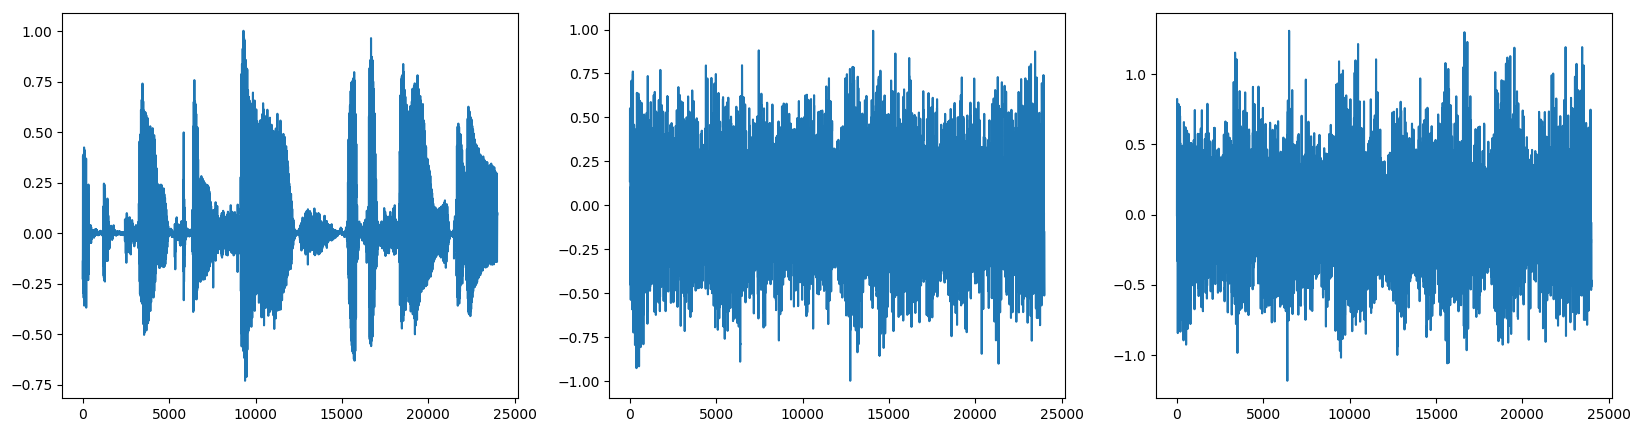

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000005EA1E160>

In [10]:
_, ax = plt.subplots(ncols=3, figsize=(20,5))
ax[1].plot(y_speech)
ax[2].plot(y_noise)
ax[3].plot(y_tot)

## Train GMM on data

In [11]:
# train GMMs 
Ns = 10
Nn = 2
g_speech = trainGMM(Ns, z_speech, :diag)
g_noise = trainGMM(Nn, z_noise, :diag)
println(avll(g_speech, z_speech))
;

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       8.743279e+04
      1       5.774661e+04      -2.968618e+04 |       10
      2       5.682947e+04      -9.171406e+02 |       10
      3       5.658670e+04      -2.427680e+02 |        9
      4       5.646032e+04      -1.263826e+02 |        9
      5       5.627707e+04      -1.832501e+02 |       10
      6       5.601558e+04      -2.614899e+02 |        9
      7       5.578895e+04      -2.266310e+02 |        7
      8       5.566489e+04      -1.240594e+02 |        8
      9       5.563262e+04      -3.226807e+01 |        7
     10       5.560415e+04      -2.846885e+01 |        7
     11       5.559557e+04      -8.581606e+00 |        5


┌ Info: Initializing GMM, 10 Gaussians diag covariance 21 dimensions using 1198 data points
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\bTNkf\src\train.jl:78


     12       5.559207e+04      -3.499035e+00 |        2
     13       5.559134e+04      -7.334099e-01 |        0
     14       5.559134e+04       0.000000e+00 |        0
K-means converged with 14 iterations (objv = 55591.33698807798)


┌ Info: K-means with 1198 data points using 14 iterations
│ 5.4 data points per parameter
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\bTNkf\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       7.565454e+04
      1       4.680257e+04      -2.885197e+04 |        2
      2       4.626990e+04      -5.326679e+02 |        2
      3       4.614736e+04      -1.225392e+02 |        2
      4       4.610114e+04      -4.622714e+01 |        2
      5       4.608319e+04      -1.794783e+01 |        2
      6       4.606514e+04      -1.804706e+01 |        2
      7       4.604671e+04      -1.842861e+01 |        2
      8       4.603482e+04      -1.189266e+01 |        2
      9       4.602538e+04      -9.443814e+00 |        2
     10       4.601186e+04      -1.351790e+01 |        2
     11       4.599268e+04      -1.917544e+01 |        2
     12       4.598349e+04      -9.187171e+00 |        2
     13       4.598174e+04      -1.757268e+00 |        2
     14       4.598095e+04      -7.862672e-01 |        2
     15       4.597685e+04      -4.099724e+00 |        

┌ Info: Initializing GMM, 2 Gaussians diag covariance 21 dimensions using 1198 data points
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\bTNkf\src\train.jl:78


.503030e+04      -3.530621e+00 |        2
     49       4.502843e+04      -1.870032e+00 |        2
     50       4.502437e+04      -4.063267e+00 |        2
     51       4.502227e+04      -2.093749e+00 |        2
     52       4.502203e+04      -2.441844e-01 |        2
     53       4.502185e+04      -1.803691e-01 |        0
     54       4.502185e+04       0.000000e+00 |        0
K-means converged with 54 iterations (objv = 45021.850109077874)


┌ Info: K-means with 1198 data points using 54 iterations
│ 27.2 data points per parameter
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\bTNkf\src\train.jl:139


-1.851867518955374


## Perform ALGONQUIN

In [12]:
# create output array
z_pred = Array{Float64, 2}(undef, size(z_tot,1), 3*size(z_tot,2))

@showprogress "Computing..." for k = 1:size(z_tot,1)
    z_pred[k,:] = ALGONQUIN_frame(g_speech, g_noise, z_tot[k,:])
end
;

Computing...100%|███████████████████████████████████████| Time: 0:03:49


In [13]:
z_speech_pred = z_pred[:,1:Int(floor(size(z_pred,2)/3))]
z_speech_pred = hcat(z_speech_pred, reverse(z_speech_pred[:,2:end-1], dims=2))
z_noise_pred = z_pred[:,Int(floor(size(z_pred,2)/3))+1:2*Int(floor(size(z_pred,2)/3))]
z_noise_pred = hcat(z_noise_pred, reverse(z_noise_pred[:,2:end-1], dims=2))
;

## Plot results with correct phase

In [14]:
speech_pred = warp_ifft(sqrt.(exp.(z_speech_pred)).*exp.(1im*angle.(f_speech)), pole_location, step_size)
noise_pred = warp_ifft(sqrt.(exp.(z_noise_pred)).*exp.(1im*angle.(f_noise)), pole_location, step_size)
;

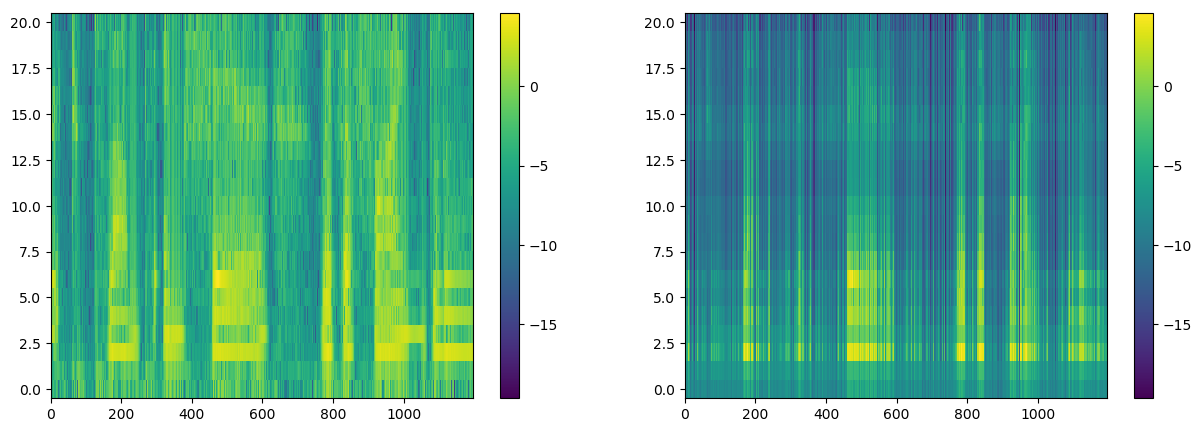

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
pcm = ax[1].imshow(z_speech', aspect="auto", origin="lower")
fig.colorbar(pcm, ax=ax[1])
ax[2].imshow(z_speech_pred[:,1:Int(nr_freqs/2+1)]', aspect="auto", origin="lower")
fig.colorbar(pcm, ax=ax[2])
;

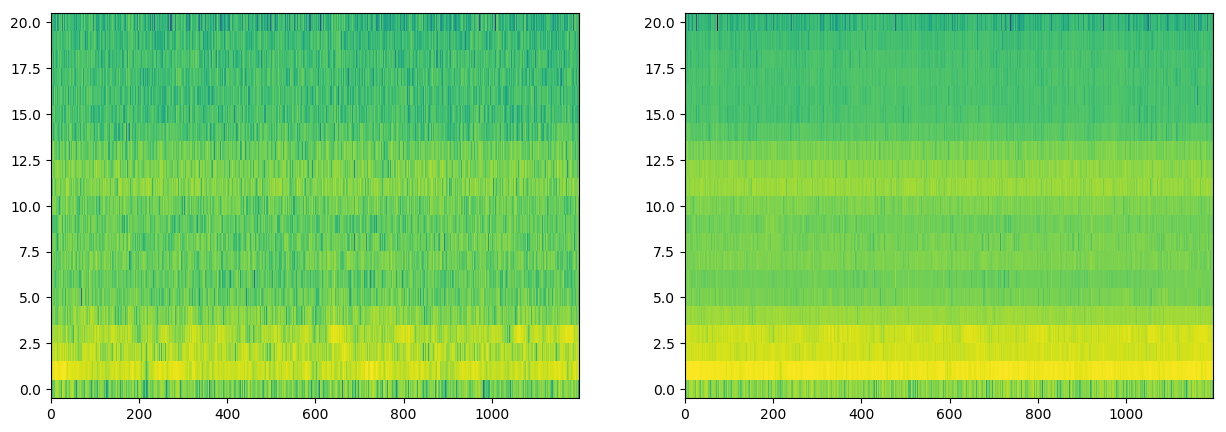

PyObject <matplotlib.image.AxesImage object at 0x00000000400C63C8>

In [16]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].imshow(z_noise', aspect="auto", origin="lower")
ax[2].imshow(z_noise_pred[:,1:Int(nr_freqs/2+1)]', aspect="auto", origin="lower")

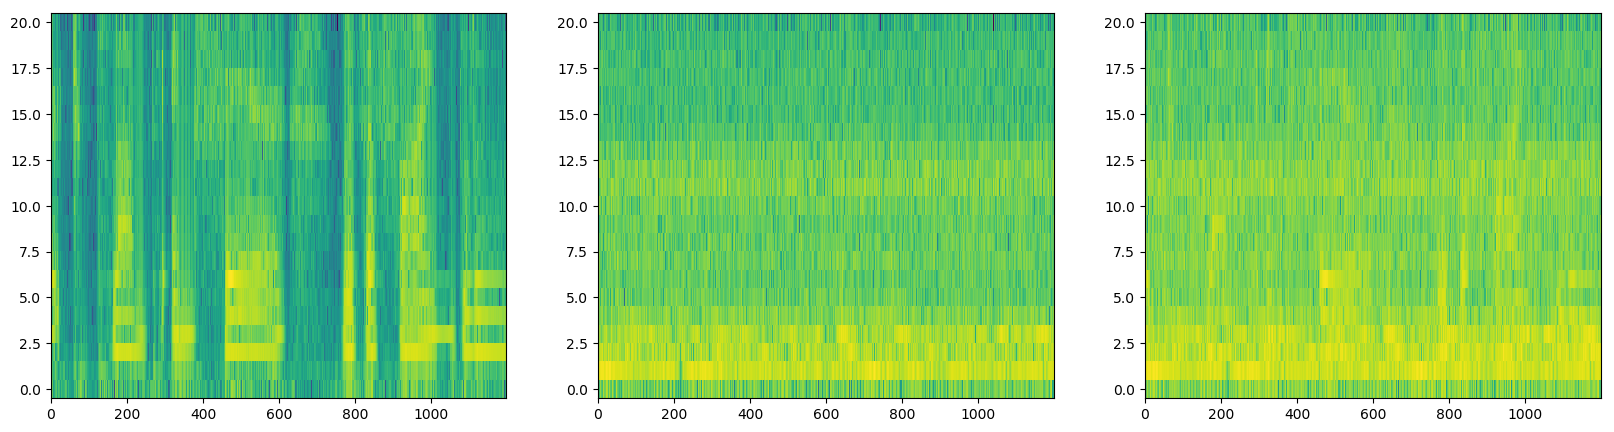

In [17]:
_, ax = plt.subplots(ncols=3, figsize=(20,5))
ax[1].imshow(z_speech', aspect="auto", origin="lower")
ax[2].imshow(z_noise', aspect="auto", origin="lower")
ax[3].imshow(z_tot', aspect="auto", origin="lower")
;

<source src="data:audio/wav;base64,UklGRkB3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQR3AQAXLxC+z7Zpvpv5Nb7BxRS+yVvfvUVPfL38sEc9gVMKPp4fZT6sOp8+RpLDPsjZwD5W47o+J/2cPmR09T0v+uG8ABMfvdIXpb07sH++OCiXvvv6Nb44zZu9eM6Yva0/Er1fmx09L+SrPe4cPj3Td6g79Y9svcGes72gmOG9KaAYvpjcUr7g8k++VXYXvuUq2b3Ba7S98BKWvE0V6z0WIGg+qiaSPtcnsj4xVMc+Y+TFPuDxqD69wBs+2NTxu1vSK71/F5i9vD17vvfDo77n4mO+8qS2vXTgrb10upW9vXA4PH9ivD1+8JY9nkMiPULRnrt0sj+9+GfJveM3A77Zhzq+DQNXvrM9OL6sCAi+sZXHvbpjMbzNJAw+UVOEPtSsoD7E7b8+lADZPjDuyz6qLmI+9XYmPSq+FjzI8Bi90mNgvt28t75p/Iu+A/EWvlMvCr6i3BS+HQoavQEv0D0Iq/89vKxwPfizijwG9Qs9jrqmPCbCrr3Z1zq+jNJEvjVxJL4keiC+3EEZvjBXnr2MpI49GgVMPhV4iz4g558+QLHGPmZX0j61LJs+IPC5Pav9lTn/17Q7GYnlvXvDpb5c6K6+oVxTvlTMHr71mze+1FzzveH14zuZzZg9n3yTPbNvHD2AEQ08FFl1PPSTUjyR6Kq94BgpvteY+r0ZPju9XzhLveXiVbvRpDA+MiaoPh8xsz4ljbg+wQigPhDOIj4g8aU9z/JTPUZa+r372qC+scqNvkacQL4qYV2++HlsvhJk0L1r9h49hYK2PZHD6z0FNvk9WjKdPVZphz1ds349YJgfvW9DQb4m1Ua+HMIFvp7XM75TKmy+RjEHvjgZTzxV2ng92D26PcCMOT4EqYI+i0mDPsGPVD6ugzA+nTT+Pd5ZkT3xbRC83llsvRsUeL2MM7K9Zi0lvnssI75Xrci9qmi8vUkO6b25a3+9WxlBPIrrMbp3VjG9LP9DvX5R6bw4Y8C8yXmxvHVINLt5PVw9ZmgYPgJFbz52tZA+wOSpPkjMvD4cb10+Vm88PAl83js3LbM8YPhIvo/NvL5g8nK+dWXcvZbBRL5zn12+/pvOvFIVBT4EjQA+pJjcPXo8Kz7HFUc+/HAiPkS9jD0YLKG8DyWqvVi5yL26PQi+6EhIvjMYSL690Oe9d5x2vfPRhb3/iQe93rIZPc3ImD1w7EI9tIwWPRM6Iz12ePo8nF+evDZ0Wr19ITy9syPvvG29Er15zyi9GHsOvY9/fLz0kdU7UhQJPK29SbuupwW79bNwPKqtezsR28C8Q+kXvUARabyojWC8mO+ovOtARztuQAE9O+oRPY3LIT1TEmI9vn2EPcHQgz3EujY99mz+PN5srjyxd388neOGvOCDPL1jlki9KPNLvaiFkr0oW6C9Ln1uvTsOVb1AKly951kvve3xuLxGoaq8Qf5avI9sMTqm8lU8kjemPCPtPz3CPog9JVyJPUujoj18Htg9md/QPdIjqj2p2nM9GmcyPcUijzz7qcK8CXCJvXfc273twPu9SAf9vdNDBr63pBO+BRbqvTnfoL1asH29sqw4vYkKU7yfsCY8TInsPATsOD2tXGA9K3CdPfjN+j19jx0+HJc2Pk8AST4o1Ds+PEj6PcNEoz1OXjE9YVF6vXRoFr6T7ya+3KYqvtU1Zb7x9m2+/j0qvj428r0Zzum9xu6fvX7Q07tXrfA89JYiPYvTgj1k0Mo9iFTtPf3jAj4mTCc+cPBTPtYIdj6udmU+htXiPdV63Dwge1M9vX+dPMapEr735k++J+/CvQP7yr1nqU++0uQkvl9bpLzLzSW82hRBvXOvBz2OiOY9xPysPeHRRz3ahps9njuJPdkRpbsLRiy9cQUIvVe1cr1lJMq934HHveZXrr21qKC9TDiGvUnZL71YbZq84zRIvNWEdrwBssm7wMkpPM4rejzys/m76LGTuz0cLTykokE675GBvJZF3zqYr4E7isl6vKC5mLzmlDK877QhvCFiBLzrGwe6r07jOw+O5TuOvjs8hukfPHiPyjzZqSc9jOQCPWK/kTygYcs8prkOPdttqjw/CpE8t4bXPGwJkTxap6Y6fBP7OREFTbvFfRa8XxkQvOODHryLh/a7pHUmvL8viLv2IGy6uT3bujm90juoq907o3DyOwS4qjx/f6E8uRUgPLAyxzzr6u08fnY0PIqvADzeMdU8HSPQPOZwLjwI0xA8sAVSOzILqTokr5Q8kIm7O6IDg7znR+I6RTyOPL3EVrrK1sK7JZYDPDQ/szrRZ7Y7AIsmPBIvLDtIeyE7jBFaPDsFgDwAARs7hH8RPMzaTDyuOTw8zlTBPF2iyLo6ZJE8tPL0PNly1DtaB6s8SWicPMMzlbt9/ms8v/nEPKj4t7sMHI68kXQfOylYF7wQM0S8jqePO/gdALyFJiO79ZswPACm2Lxa+Da82j4PPTaVJDyygB69V96ivIolHj2vutY7sk05va6Cgjyi37M8f8dDvao/ITxQohA9G/Y2vWzkG7087vA8ds8gvHZAQr26KMe8BatsOg8e1rzddmC8Z9CCvMRz77zPfvo7IMpiPB0xRb2nppq8vr/xPLrtm7y4cQO9cV1iO98/R7qi6Ka8G8mYvEQiyDua4ku8Ix3yvMQpU7xLgY27j9Z+vH5R9rxO21i8xhomvG8TZ7xzjhG8FGmnuzRCarpED0K7Piphu4HWE7vWSow7K2tVusQh+LvaO5m62L7Luia8LLosKQC89vnuuxNNsbuJ1mW7HxDcOpENmDrwfVe4H8NhO505vjtvWYq7umlcu/lLbLuzBRW8uSUyvJNWI7yYOge853JsvCCbcbzEExi8dieCu6qi/rqmyGa7amHZO4RmPzyjY+E7JtqRO9AZDTyP+NM7cx4kO2+gczs/Bqk6dB+yOZ95gToomHe6duJ8ul2fBLtO4IM5qREzO8exSLsmhMq7zkXQu2lzDLxGUwa80nASvEz5mLt5esG5IXlaOyU8qDvIF5S5t/+XO8gjFTylxNs7+IHMufnwGDtobfk7AQMcOzJSO7uFx3Y75hbiO3Wgfjvm6Ii6sF+SOzpfzDtW9v87eOkPPADrQjzBxjo819owPDZQOTwbKQY8BjQJPNf9CjzdWSo7tTmeOwf7yzsilA08p89APAge/jvKXPQ78RcLPC218jvtO9Q7+N7dO7FfPTxVjyM8TU6aO0H28zv+bxY8JLL2O1zUZjzSvH48ZMY1PJ4TETzei0A8wx/BO2GtgjuNAL47QZFhu90NubtkewK8cOGLu2ansbu81me7TgNhO5bEcDuRUjg61wsJO0ZtOjs/mCK6FAPBu2KV77vH1Cu8SXgivEy3TbwE/oe88OKTvF7TfbyEho+8oKyXvHYSUrxByne8n4aGvP3NirwysYK8B5mdvBpjp7wcYKO8sFe5vKGqrLxUgaq8/TygvG3eurwW+HG8vLFQvK58j7yxnl+8qD9bvMu4OLxnvYO8LF6jvEvuo7zclJ+8OtB+vK2Khbzr74G8D7R7vE80c7wNDI68VpiVvNH8dLyHfji8r5p/vEljY7yaeSO8jH4XvB9mILz6QYC7WDAFvBtELrykpfO7xXF9u0yikLvsYHK7A3zfu3nYPrtvjP43F5YGu1T9vTr3LmA6Xy8vOyoTaTtfRoo6rANJO+pBQzuGWLK7Gh0WusPwgzqXDfQ6mtKgOqpKgDtpneo70NaMO4hIyTslITU8UscMPGiMUDw313I8v+MoPDIvQzzHsAw8lpQ7PF8yGDxrCyM8mORJPLBP+Dufq/c7xpsjPJOQZDw86x48J6lAPCwxfjxhQDg8WXcQPC16VzwATHM8W3GKPEi8gjx/tHk8PXhuPLExmzxGg448aMlIPOf8QzyiX

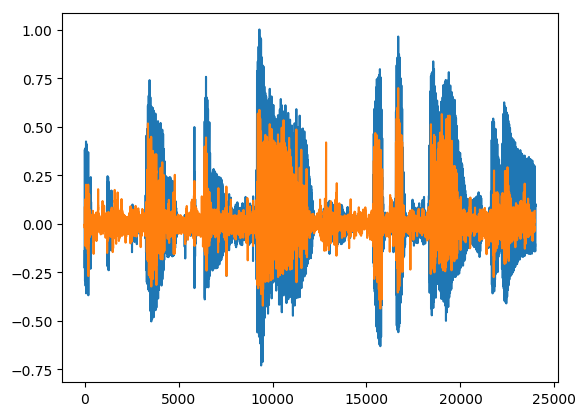

In [18]:
plt.plot(y_speech)
plt.plot(speech_pred)
audioplayers(y_speech, speech_pred, y_tot, fs=fs_desired)

<source src="data:audio/wav;base64,UklGRkB3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQR3AQCsZgw+p76QPi+woD5FjbU+F4u1PmTHzD58EOo+RkkDP68iDT9uSgM/fvvdPlgozT5cGbw+RErRPjlKzz6kJMc+/Q6YPlbLjz4wAJI+jjquPnVEmD4Qyns+m7mBPu+gBj7PAi8+AvwiPq5FVbyWY0G+Eud+vkwLKL4wNr85DNvOPfZu+7sP6c69oz08vs+tA74t2Dy9eZkNviFKLL5ECIC+q0LNvqfC5b5Zjui+GfqSvv1emb6PMni+uFKbvmhQt74yJL6+ikftvhtDBr8ujP6+lfYJv2A/9b5XacS+GX5yvmTGZL6xk5e+wR6PvuE2b76Ga1q+SvO7vT1nVr11UFy8VkvKvUDbjL5KjKS+T/FbvjGhaL2sHnA9oNyhPOYblL1og6K9tQaLPXjsbT5OOmQ+F48+PhKelD3HVfY8o/CAPtUi6T6Dvwc/OIbcPoggnT5RuK8+w6H9Ph88Ij989Ck/23IKPzeTFz+YjSE/bmE1PwnEKj+sowg/Uuz1PsDU6T5DwOg+nP3pPr6Cvj5Cgoo+hlqKPi4JvT6BIas+3g4pPgaRn7xMnB+9BJymPIs87z2VFO88IIYDvvreq75+uta+bsyzvt3aUL4bgF2+tKCkvgnXyL7krOC+QlDsvh+F3b5x2dy+I3HVvpRRvb6sbre+smyqvpQjtr7owIG+i5h4vrJLg77gIl++vn9uvuAAg77KJVC+66iFvsqAhb4x/nq+lhJ7vjaVQb6xLQ2+7wOJvovf/L4zAhi/5d4Jv7PZ177oUIe+F1FVvmVAYL752bm+20e/vm6VuL6UrKq+2WhpvmVBCr6o8yK+OJTQvUN8iL3q7Ym9ercsObeKLj7VaaI+df7CPvLdxT6+QZs+XtOZPlMHxj7qcAM/EgUlP2GFKT8w7RA/rET/PqVrAD/1UiE/E9VCPxHIKj+7BAg/82e7PkFFoz6oZ64+yx/4Pg2PMz+hCD8/Du4wPxBoCj+4fQA/JpHePr1n7D7AbNY+HsKbPiyQbT6c8UE+O0s2PlYJBT4rWd48ToyNvQ4TXL4sFm++ZuFvvlNlhr6S67K+P4wBv9dSIr8xJB6/0SEKv3/U8r4obQe/tAEev1yMOb+3/TG/tyYav1L7G79Snye/x1QSv8OkB7+CguK+OvXevooz275V7dW++ca5vmGdkL7H1pS+glSIvrAVYL5yEzy+aPk2vskKJL7iCzK+3U26vRPsRL5oW9K9tG6VPR5TpT2+gvs8RejvvZV7QL0/p2C9GlCNuBxCTD6Wj2o+2+eJPT/sbLy42TU95K9hPpgkvz7Ak+o+7bLjPiDhqz6PC7o+hYDKPqPM2z5Ba9U+yNrNPvZPtj40C5c+uD1+PuIVrj5427g+/orWPtdH0T7xxbo++fWPPjZRRT4kjKs9JbY8PuGsfz6/dLE+iIqnPl1qSj5atfE9UDWfPejhaz4RXq4+F/y7PnfrqD7Q+JY964jPPO/Ppj2WOrs9pW+CPYvAtrw+PTO9kaN7vWUy2rvDab084jUSvQY1Eb771lG+XdBdvse2KL7gc02+Q8LmvhYNA7+QMBW/FDANv882877uVQq/srosvx/SS78Erjy/GBEtv1ZFFr/8I/m+TB4Sv4xBD79a9f++CrGUvuUKQr5JOE2+eVQovuOR+b2kCP67IT2iPcQ4xj3j4909DnskPq+xkT4wMqA+VN99PrbBIj4cPaU9kK59PXLCmT5NVb4+A1a7PipelD6yua89crFKPXwPlD3RfYg+Ce6kPrTzfT67618+kA+KPj38nT5Sr7s+e+LWPtgGyz53xas+76onPlc0lD64V7s+In7cPkgVzj4yWKw+z4V+Pnk/eT4WCpE+LL+FPqlsbT75nyI+k9b1Pa8uID4Q0/49D/MJPjCWEj7GOc09Eyi1Pb4mRz10XnI97HrRPLWLq712iwm+ecnIvUq8kr1v+Cy9b5WQu9T99b1uI06+HMJzvovfWb5lrdm97A89vrIIq752dty+W4Lmvj9qB78jugK/u54Bv19iA7+iXQO/O/UUv/zrKL+K8FO/9IxtvyIzXL/lkU2/HD8vv7y6Hr8zxxa/GikUv2GHAL9POdG+XBKgvsUmOL4dWvC9fc7JvXROxj1h8m8+dFDDPly4AD+IOOA+F5uzPi1MtT4ROsw+JcLyPgOiHz94uyM/GfgSPxwk8j7hW+U+awwTP3hyHz+QHhI/22z/PlNZ2z420fY+smEOPygnCD+UMPg+Kh+/PglKtz40bK4+uJXAPi1owj7IDqY+kICOPsJyoj7tXLI+N3CsPvXhaD7y/UI+B+VlPmvghT6AyKc+bbuHPnM3Kj6FV7y6cNrIvb8bjL2AwCG+phRlvh26ib51taa+B3NqvjZzVb7uFo6+cxjevvsaFL/+Awy/tXP/vuoBB78QZxq/T2Uuv6hiH7/h3AC/a9Sovsu/iL6Z18i+AtUNv2YJHL8C1AO/RKO/vob3pr71DZW+FI2cvvO6o76hNUi+cJo3vpUyQ778jBq+ryHbvQ7bjb1Osk69w8+qva5wTb6J5k2+FqBDvVhb9j0IUFM+eo34PWXp2j0wRdI8PQYIPgOVHj68EIA90kVLPdSodj3A9zM+suOOPltQoT6oNpc+gT+mPs62xj7RP/k+rPcZP/6mIj8ECwQ/64HmPpdH7j58tc4+MK4KP+TX8z4jw+A+saUEP1OMDz+u0Ac/TNYIP9r0Gz9FXgc/jMXxPm9jzT4kZZs+FJCUPscHtT4d3a0+slNVPjSIwz0zyTO89VQFvrfLBL4qo4K+rnB0vq4ok74Vx6K+YZ/MvmIbFL/4USe/+BUVv8PhAb9dAgi/76Ukv8W7Vb/932q/ilhjv+32Q7+G1g+/PhMGv7To/L7jPfC+p0rzvv5b4b4EtcW+Kbfmvgips75cvYq+xKQHvi/Ohb053tO998hNvnaxbL72Qxq+TkGHPd/9ZD2J+x+937vIvZFza72C9F09IJtRPjzxbT4hXD8+GkAlPiUEaT4V2Yo+4+LNPoyl9z7betQ+asvHPqNKzD7MFtc+ePubPqgbXD55QMs9T+9XPtQFuz57tP4+5MThPmnYmD6BXSA+pwFCPlCsuD6vheg+pdvpPgZg9z5tnOQ+1CwUP9i7Fj/IEBg/0In8PuWLuj4OW5w+UGe3PqxC9T4xtA0/PqX6Pshypz4boz8+uT4GPmCwJT7J0So+zHbpPa1U+bydbaC98b4Qvrx62LziwwA9SLpsPI2P7r09Xny+3ty6vnvNBr89JBi/+q0ev2XjF797XiK/zWwUv3HdC78UFRe/GJISv6QXDL9J8h2/eagmv4zaKL/j+y2/Z+pOv5aSTL8fpjK/R3stv8qqGb9rCPu+qY/vvu9Dxr5cV8u+/R7ivuJvrb49G56+E9WOvjexVr6h5VG+D03OvbuhuDwp4e49VzpuPi48gT5nF5Q+n5yVPjp8hD7dd6Y+Ala/PnT9rD7gIro+VS2xPvoDmT721s8+jgfIPgXD0T70Hrs+ubiaPki7NT46eg4+1SNHPeOkPj4XwZM+oWbEPlMMqz6hzmg+64OPPnTJuT4w3cE+p9GMPo+9Fz7qHm88unRmPnvJ4D4YWBU/g6MJP5Kzrz7VjAY+mhqHPX8z+j1Yv5s+U16iPrAzVD5Gtim9TB80vpdW7r2WfG89XDm9PU0cJL31fBK+P+Jivn3pnb7o7a2+RT/Cvs2M8b7PQAy/tBr2vuY+777ZjM++CRvKvmbB5b7RTOK+zl/3vlBWAb+n6/G+ZjX0voqMx76IPIq+gxBZvnLeKL5O8Ui+zOVDvvpFHTyyk4E+SHvTPvSpoz7SnBo+L+HzPHd+uTzrcCU+aBuhPp1Psj45tqw+87w/Pr1t8z29O4A+bZe+Pt6c2j6x0

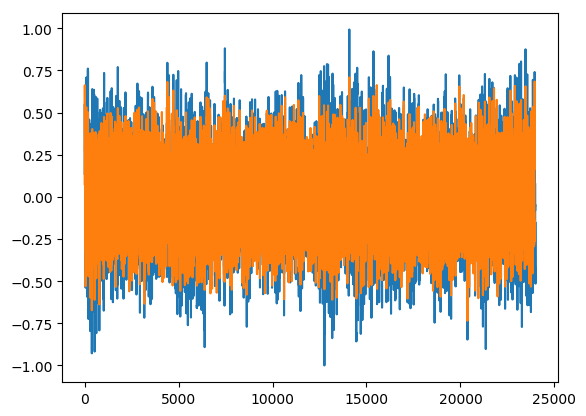

In [19]:
plt.plot(y_noise)
plt.plot(noise_pred)
audioplayers(y_noise, noise_pred, y_tot, fs=fs_desired)

## Plot results with total phase

In [20]:
speech_pred = warp_ifft(sqrt.(exp.(z_speech_pred)).*exp.(1im*angle.(f_tot)), pole_location, step_size)
noise_pred = warp_ifft(sqrt.(exp.(z_noise_pred)).*exp.(1im*angle.(f_tot)), pole_location, step_size)
;

<source src="data:audio/wav;base64,UklGRkB3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQR3AQAXLxC+z7Zpvpv5Nb7BxRS+yVvfvUVPfL38sEc9gVMKPp4fZT6sOp8+RpLDPsjZwD5W47o+J/2cPmR09T0v+uG8ABMfvdIXpb07sH++OCiXvvv6Nb44zZu9eM6Yva0/Er1fmx09L+SrPe4cPj3Td6g79Y9svcGes72gmOG9KaAYvpjcUr7g8k++VXYXvuUq2b3Ba7S98BKWvE0V6z0WIGg+qiaSPtcnsj4xVMc+Y+TFPuDxqD69wBs+2NTxu1vSK71/F5i9vD17vvfDo77n4mO+8qS2vXTgrb10upW9vXA4PH9ivD1+8JY9nkMiPULRnrt0sj+9+GfJveM3A77Zhzq+DQNXvrM9OL6sCAi+sZXHvbpjMbzNJAw+UVOEPtSsoD7E7b8+lADZPjDuyz6qLmI+9XYmPSq+FjzI8Bi90mNgvt28t75p/Iu+A/EWvlMvCr6i3BS+HQoavQEv0D0Iq/89vKxwPfizijwG9Qs9jrqmPCbCrr3Z1zq+jNJEvjVxJL4keiC+3EEZvjBXnr2MpI49GgVMPhV4iz4g558+QLHGPmZX0j61LJs+IPC5Pav9lTn/17Q7GYnlvXvDpb5c6K6+oVxTvlTMHr71mze+1FzzveH14zuZzZg9n3yTPbNvHD2AEQ08FFl1PPSTUjyR6Kq94BgpvteY+r0ZPju9XzhLveXiVbvRpDA+MiaoPh8xsz4ljbg+wQigPhDOIj4g8aU9z/JTPUZa+r372qC+scqNvkacQL4qYV2++HlsvhJk0L1r9h49hYK2PZHD6z0FNvk9WjKdPVZphz1ds349YJgfvW9DQb4m1Ua+HMIFvp7XM75TKmy+RjEHvjgZTzxV2ng92D26PcCMOT4EqYI+i0mDPsGPVD6ugzA+nTT+Pd5ZkT3xbRC83llsvRsUeL2MM7K9Zi0lvnssI75Xrci9qmi8vUkO6b25a3+9WxlBPIrrMbp3VjG9LP9DvX5R6bw4Y8C8yXmxvHVINLt5PVw9ZmgYPgJFbz52tZA+wOSpPkjMvD4cb10+Vm88PAl83js3LbM8YPhIvo/NvL5g8nK+dWXcvZbBRL5zn12+/pvOvFIVBT4EjQA+pJjcPXo8Kz7HFUc+/HAiPkS9jD0YLKG8DyWqvVi5yL26PQi+6EhIvjMYSL690Oe9d5x2vfPRhb3/iQe93rIZPc3ImD1w7EI9tIwWPRM6Iz12ePo8nF+evDZ0Wr19ITy9syPvvG29Er15zyi9GHsOvY9/fLz0kdU7UhQJPK29SbuupwW79bNwPKqtezsR28C8Q+kXvUARabyojWC8mO+ovOtARztuQAE9O+oRPY3LIT1TEmI9vn2EPcHQgz3EujY99mz+PN5srjyxd388neOGvOCDPL1jlki9KPNLvaiFkr0oW6C9Ln1uvTsOVb1AKly951kvve3xuLxGoaq8Qf5avI9sMTqm8lU8kjemPCPtPz3CPog9JVyJPUujoj18Htg9md/QPdIjqj2p2nM9GmcyPcUijzz7qcK8CXCJvXfc273twPu9SAf9vdNDBr63pBO+BRbqvTnfoL1asH29sqw4vYkKU7yfsCY8TInsPATsOD2tXGA9K3CdPfjN+j19jx0+HJc2Pk8AST4o1Ds+PEj6PcNEoz1OXjE9YVF6vXRoFr6T7ya+3KYqvtU1Zb7x9m2+/j0qvj428r0Zzum9xu6fvX7Q07tXrfA89JYiPYvTgj1k0Mo9iFTtPf3jAj4mTCc+cPBTPtYIdj6udmU+htXiPdV63Dwge1M9vX+dPMapEr735k++J+/CvQP7yr1nqU++0uQkvl9bpLzLzSW82hRBvXOvBz2OiOY9xPysPeHRRz3ahps9njuJPdkRpbsLRiy9cQUIvVe1cr1lJMq934HHveZXrr21qKC9TDiGvUnZL71YbZq84zRIvNWEdrwBssm7wMkpPM4rejzys/m76LGTuz0cLTykokE675GBvJZF3zqYr4E7isl6vKC5mLzmlDK877QhvCFiBLzrGwe6r07jOw+O5TuOvjs8hukfPHiPyjzZqSc9jOQCPWK/kTygYcs8prkOPdttqjw/CpE8t4bXPGwJkTxap6Y6fBP7OREFTbvFfRa8XxkQvOODHryLh/a7pHUmvL8viLv2IGy6uT3bujm90juoq907o3DyOwS4qjx/f6E8uRUgPLAyxzzr6u08fnY0PIqvADzeMdU8HSPQPOZwLjwI0xA8sAVSOzILqTokr5Q8kIm7O6IDg7znR+I6RTyOPL3EVrrK1sK7JZYDPDQ/szrRZ7Y7AIsmPBIvLDtIeyE7jBFaPDsFgDwAARs7hH8RPMzaTDyuOTw8zlTBPF2iyLo6ZJE8tPL0PNly1DtaB6s8SWicPMMzlbt9/ms8v/nEPKj4t7sMHI68kXQfOylYF7wQM0S8jqePO/gdALyFJiO79ZswPACm2Lxa+Da82j4PPTaVJDyygB69V96ivIolHj2vutY7sk05va6Cgjyi37M8f8dDvao/ITxQohA9G/Y2vWzkG7087vA8ds8gvHZAQr26KMe8BatsOg8e1rzddmC8Z9CCvMRz77zPfvo7IMpiPB0xRb2nppq8vr/xPLrtm7y4cQO9cV1iO98/R7qi6Ka8G8mYvEQiyDua4ku8Ix3yvMQpU7xLgY27j9Z+vH5R9rxO21i8xhomvG8TZ7xzjhG8FGmnuzRCarpED0K7Piphu4HWE7vWSow7K2tVusQh+LvaO5m62L7Luia8LLosKQC89vnuuxNNsbuJ1mW7HxDcOpENmDrwfVe4H8NhO505vjtvWYq7umlcu/lLbLuzBRW8uSUyvJNWI7yYOge853JsvCCbcbzEExi8dieCu6qi/rqmyGa7amHZO4RmPzyjY+E7JtqRO9AZDTyP+NM7cx4kO2+gczs/Bqk6dB+yOZ95gToomHe6duJ8ul2fBLtO4IM5qREzO8exSLsmhMq7zkXQu2lzDLxGUwa80nASvEz5mLt5esG5IXlaOyU8qDvIF5S5t/+XO8gjFTylxNs7+IHMufnwGDtobfk7AQMcOzJSO7uFx3Y75hbiO3Wgfjvm6Ii6sF+SOzpfzDtW9v87eOkPPADrQjzBxjo819owPDZQOTwbKQY8BjQJPNf9CjzdWSo7tTmeOwf7yzsilA08p89APAge/jvKXPQ78RcLPC218jvtO9Q7+N7dO7FfPTxVjyM8TU6aO0H28zv+bxY8JLL2O1zUZjzSvH48ZMY1PJ4TETzei0A8wx/BO2GtgjuNAL47QZFhu90NubtkewK8cOGLu2ansbu81me7TgNhO5bEcDuRUjg61wsJO0ZtOjs/mCK6FAPBu2KV77vH1Cu8SXgivEy3TbwE/oe88OKTvF7TfbyEho+8oKyXvHYSUrxByne8n4aGvP3NirwysYK8B5mdvBpjp7wcYKO8sFe5vKGqrLxUgaq8/TygvG3eurwW+HG8vLFQvK58j7yxnl+8qD9bvMu4OLxnvYO8LF6jvEvuo7zclJ+8OtB+vK2Khbzr74G8D7R7vE80c7wNDI68VpiVvNH8dLyHfji8r5p/vEljY7yaeSO8jH4XvB9mILz6QYC7WDAFvBtELrykpfO7xXF9u0yikLvsYHK7A3zfu3nYPrtvjP43F5YGu1T9vTr3LmA6Xy8vOyoTaTtfRoo6rANJO+pBQzuGWLK7Gh0WusPwgzqXDfQ6mtKgOqpKgDtpneo70NaMO4hIyTslITU8UscMPGiMUDw313I8v+MoPDIvQzzHsAw8lpQ7PF8yGDxrCyM8mORJPLBP+Dufq/c7xpsjPJOQZDw86x48J6lAPCwxfjxhQDg8WXcQPC16VzwATHM8W3GKPEi8gjx/tHk8PXhuPLExmzxGg448aMlIPOf8QzyiX

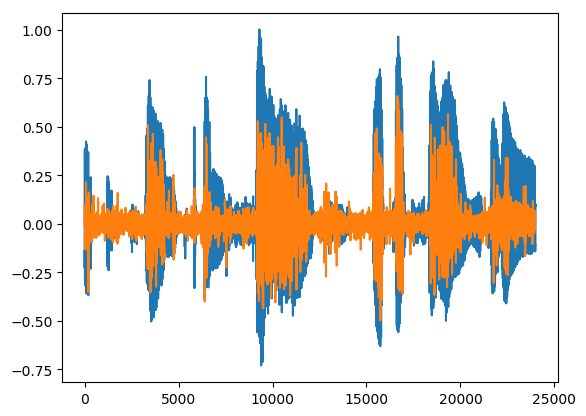

In [21]:
plt.plot(y_speech)
plt.plot(speech_pred)
audioplayers(y_speech, speech_pred, y_tot, fs=fs_desired)

<source src="data:audio/wav;base64,UklGRkB3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQR3AQCsZgw+p76QPi+woD5FjbU+F4u1PmTHzD58EOo+RkkDP68iDT9uSgM/fvvdPlgozT5cGbw+RErRPjlKzz6kJMc+/Q6YPlbLjz4wAJI+jjquPnVEmD4Qyns+m7mBPu+gBj7PAi8+AvwiPq5FVbyWY0G+Eud+vkwLKL4wNr85DNvOPfZu+7sP6c69oz08vs+tA74t2Dy9eZkNviFKLL5ECIC+q0LNvqfC5b5Zjui+GfqSvv1emb6PMni+uFKbvmhQt74yJL6+ikftvhtDBr8ujP6+lfYJv2A/9b5XacS+GX5yvmTGZL6xk5e+wR6PvuE2b76Ga1q+SvO7vT1nVr11UFy8VkvKvUDbjL5KjKS+T/FbvjGhaL2sHnA9oNyhPOYblL1og6K9tQaLPXjsbT5OOmQ+F48+PhKelD3HVfY8o/CAPtUi6T6Dvwc/OIbcPoggnT5RuK8+w6H9Ph88Ij989Ck/23IKPzeTFz+YjSE/bmE1PwnEKj+sowg/Uuz1PsDU6T5DwOg+nP3pPr6Cvj5Cgoo+hlqKPi4JvT6BIas+3g4pPgaRn7xMnB+9BJymPIs87z2VFO88IIYDvvreq75+uta+bsyzvt3aUL4bgF2+tKCkvgnXyL7krOC+QlDsvh+F3b5x2dy+I3HVvpRRvb6sbre+smyqvpQjtr7owIG+i5h4vrJLg77gIl++vn9uvuAAg77KJVC+66iFvsqAhb4x/nq+lhJ7vjaVQb6xLQ2+7wOJvovf/L4zAhi/5d4Jv7PZ177oUIe+F1FVvmVAYL752bm+20e/vm6VuL6UrKq+2WhpvmVBCr6o8yK+OJTQvUN8iL3q7Ym9ercsObeKLj7VaaI+df7CPvLdxT6+QZs+XtOZPlMHxj7qcAM/EgUlP2GFKT8w7RA/rET/PqVrAD/1UiE/E9VCPxHIKj+7BAg/82e7PkFFoz6oZ64+yx/4Pg2PMz+hCD8/Du4wPxBoCj+4fQA/JpHePr1n7D7AbNY+HsKbPiyQbT6c8UE+O0s2PlYJBT4rWd48ToyNvQ4TXL4sFm++ZuFvvlNlhr6S67K+P4wBv9dSIr8xJB6/0SEKv3/U8r4obQe/tAEev1yMOb+3/TG/tyYav1L7G79Snye/x1QSv8OkB7+CguK+OvXevooz275V7dW++ca5vmGdkL7H1pS+glSIvrAVYL5yEzy+aPk2vskKJL7iCzK+3U26vRPsRL5oW9K9tG6VPR5TpT2+gvs8RejvvZV7QL0/p2C9GlCNuBxCTD6Wj2o+2+eJPT/sbLy42TU95K9hPpgkvz7Ak+o+7bLjPiDhqz6PC7o+hYDKPqPM2z5Ba9U+yNrNPvZPtj40C5c+uD1+PuIVrj5427g+/orWPtdH0T7xxbo++fWPPjZRRT4kjKs9JbY8PuGsfz6/dLE+iIqnPl1qSj5atfE9UDWfPejhaz4RXq4+F/y7PnfrqD7Q+JY964jPPO/Ppj2WOrs9pW+CPYvAtrw+PTO9kaN7vWUy2rvDab084jUSvQY1Eb771lG+XdBdvse2KL7gc02+Q8LmvhYNA7+QMBW/FDANv882877uVQq/srosvx/SS78Erjy/GBEtv1ZFFr/8I/m+TB4Sv4xBD79a9f++CrGUvuUKQr5JOE2+eVQovuOR+b2kCP67IT2iPcQ4xj3j4909DnskPq+xkT4wMqA+VN99PrbBIj4cPaU9kK59PXLCmT5NVb4+A1a7PipelD6yua89crFKPXwPlD3RfYg+Ce6kPrTzfT67618+kA+KPj38nT5Sr7s+e+LWPtgGyz53xas+76onPlc0lD64V7s+In7cPkgVzj4yWKw+z4V+Pnk/eT4WCpE+LL+FPqlsbT75nyI+k9b1Pa8uID4Q0/49D/MJPjCWEj7GOc09Eyi1Pb4mRz10XnI97HrRPLWLq712iwm+ecnIvUq8kr1v+Cy9b5WQu9T99b1uI06+HMJzvovfWb5lrdm97A89vrIIq752dty+W4Lmvj9qB78jugK/u54Bv19iA7+iXQO/O/UUv/zrKL+K8FO/9IxtvyIzXL/lkU2/HD8vv7y6Hr8zxxa/GikUv2GHAL9POdG+XBKgvsUmOL4dWvC9fc7JvXROxj1h8m8+dFDDPly4AD+IOOA+F5uzPi1MtT4ROsw+JcLyPgOiHz94uyM/GfgSPxwk8j7hW+U+awwTP3hyHz+QHhI/22z/PlNZ2z420fY+smEOPygnCD+UMPg+Kh+/PglKtz40bK4+uJXAPi1owj7IDqY+kICOPsJyoj7tXLI+N3CsPvXhaD7y/UI+B+VlPmvghT6AyKc+bbuHPnM3Kj6FV7y6cNrIvb8bjL2AwCG+phRlvh26ib51taa+B3NqvjZzVb7uFo6+cxjevvsaFL/+Awy/tXP/vuoBB78QZxq/T2Uuv6hiH7/h3AC/a9Sovsu/iL6Z18i+AtUNv2YJHL8C1AO/RKO/vob3pr71DZW+FI2cvvO6o76hNUi+cJo3vpUyQ778jBq+ryHbvQ7bjb1Osk69w8+qva5wTb6J5k2+FqBDvVhb9j0IUFM+eo34PWXp2j0wRdI8PQYIPgOVHj68EIA90kVLPdSodj3A9zM+suOOPltQoT6oNpc+gT+mPs62xj7RP/k+rPcZP/6mIj8ECwQ/64HmPpdH7j58tc4+MK4KP+TX8z4jw+A+saUEP1OMDz+u0Ac/TNYIP9r0Gz9FXgc/jMXxPm9jzT4kZZs+FJCUPscHtT4d3a0+slNVPjSIwz0zyTO89VQFvrfLBL4qo4K+rnB0vq4ok74Vx6K+YZ/MvmIbFL/4USe/+BUVv8PhAb9dAgi/76Ukv8W7Vb/932q/ilhjv+32Q7+G1g+/PhMGv7To/L7jPfC+p0rzvv5b4b4EtcW+Kbfmvgips75cvYq+xKQHvi/Ohb053tO998hNvnaxbL72Qxq+TkGHPd/9ZD2J+x+937vIvZFza72C9F09IJtRPjzxbT4hXD8+GkAlPiUEaT4V2Yo+4+LNPoyl9z7betQ+asvHPqNKzD7MFtc+ePubPqgbXD55QMs9T+9XPtQFuz57tP4+5MThPmnYmD6BXSA+pwFCPlCsuD6vheg+pdvpPgZg9z5tnOQ+1CwUP9i7Fj/IEBg/0In8PuWLuj4OW5w+UGe3PqxC9T4xtA0/PqX6Pshypz4boz8+uT4GPmCwJT7J0So+zHbpPa1U+bydbaC98b4Qvrx62LziwwA9SLpsPI2P7r09Xny+3ty6vnvNBr89JBi/+q0ev2XjF797XiK/zWwUv3HdC78UFRe/GJISv6QXDL9J8h2/eagmv4zaKL/j+y2/Z+pOv5aSTL8fpjK/R3stv8qqGb9rCPu+qY/vvu9Dxr5cV8u+/R7ivuJvrb49G56+E9WOvjexVr6h5VG+D03OvbuhuDwp4e49VzpuPi48gT5nF5Q+n5yVPjp8hD7dd6Y+Ala/PnT9rD7gIro+VS2xPvoDmT721s8+jgfIPgXD0T70Hrs+ubiaPki7NT46eg4+1SNHPeOkPj4XwZM+oWbEPlMMqz6hzmg+64OPPnTJuT4w3cE+p9GMPo+9Fz7qHm88unRmPnvJ4D4YWBU/g6MJP5Kzrz7VjAY+mhqHPX8z+j1Yv5s+U16iPrAzVD5Gtim9TB80vpdW7r2WfG89XDm9PU0cJL31fBK+P+Jivn3pnb7o7a2+RT/Cvs2M8b7PQAy/tBr2vuY+777ZjM++CRvKvmbB5b7RTOK+zl/3vlBWAb+n6/G+ZjX0voqMx76IPIq+gxBZvnLeKL5O8Ui+zOVDvvpFHTyyk4E+SHvTPvSpoz7SnBo+L+HzPHd+uTzrcCU+aBuhPp1Psj45tqw+87w/Pr1t8z29O4A+bZe+Pt6c2j6x0

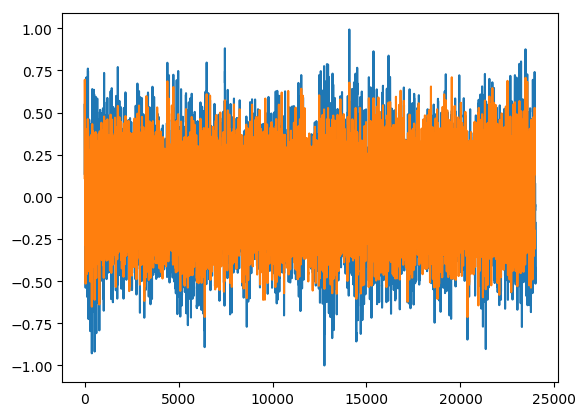

In [22]:
plt.plot(y_noise)
plt.plot(noise_pred)
audioplayers(y_noise, noise_pred, y_tot, fs=fs_desired)